**Table of contents**<a id='toc0_'></a>    
1. [Daten Vorbereiten](#toc1_)    
1.1. [df_sales](#toc1_1_)    
1.1.1. [Daten übersetzen](#toc1_1_1_)    
1.1.2. [Daten Dimensionen und Dateiformate](#toc1_1_2_)    
1.1.3. [df_sales["Feiertag"]](#toc1_1_3_)    
1.1.4. [Suche nach fehlenden Werten](#toc1_1_4_)    
1.1.5. [Suche nach Duplikaten](#toc1_1_5_)    
1.2. [df_store](#toc1_2_)    
1.2.1. [Daten übersetzen](#toc1_2_1_)    
1.2.2. [Daten Dimensionen und Formate](#toc1_2_2_)    
1.2.3. [Suche nach fehlenden Werten](#toc1_2_3_)    
1.2.4. [Imputation](#toc1_2_4_)    
1.2.4.1. [Wettbewerber_Distanz](#toc1_2_4_1_)    
1.2.4.2. [Promo2_Interval, _seit_Woche und _seit_Jahr](#toc1_2_4_2_)    
1.2.4.3. [Wettbew_offen_seit_Jahr und _offen_seit_Monat mit KNNImputer](#toc1_2_4_3_)    
1.2.5. [Dublikate](#toc1_2_5_)    
1.2.6. [Dateiformate](#toc1_2_6_)    
1.2.7. [kategoriale Spalten](#toc1_2_7_)    
1.3. [Dataframes kombinieren und Infos aus Features extrahieren](#toc1_3_)    
1.3.1. [Dataframes zu df_daily kombinieren](#toc1_3_1_)    
1.3.2. [Promo2 Features](#toc1_3_2_)    
1.3.3. [Wettbewerber Features](#toc1_3_3_)    
1.3.4. [Bundesländer Mapping nach Schulferien](#toc1_3_4_)    
1.3.5. [temporale Features hinzufügen](#toc1_3_5_)    
1.3.6. [Datenpunkte ohne Umsätze rausfiltern](#toc1_3_6_)    
1.3.7. [aggregierte Ansicht](#toc1_3_7_)    
1.3.8. [Gruppierung basierend auf Umsatz pro Kunde](#toc1_3_8_)    
1.3.9. [dataframes als pkl abspeichern](#toc1_3_9_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=4
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time

#plotten
import matplotlib.pyplot as plt
import seaborn as sns

#Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline
import kaleido

from IPython.display import display, HTML
from functools import reduce
import joblib
import pyarrow as pa
from scipy.stats import anderson, randint, ttest_ind
pd.set_option('display.max_columns', None)

# machine Learning
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.feature_selection import SelectPercentile, f_regression, RFE, SelectFromModel
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, KFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer

# 1. <a id='toc1_'></a>Daten Vorbereiten [&#9650;](#toc0_)

Im ersten Schritt werden die Datensätze näher angeschaut, fehlende Werte werden untersucht und neue Features werden für weitere Analysen erstellt.  
Wir beginnen mit df_sales (df_train Datei), dann df_stores und kombinieren diese im Anschluss.

## 1.1. <a id='toc1_1_'></a>df_sales [&#9650;](#toc0_)

In [ ]:
round(df_sales_raw.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.43,321.91,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,4.00,2.00,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.15,464.41,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.83,0.38,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.38,0.49,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.18,0.38,0.0,0.0,0.0,0.0,1.0


Im Durchschninitt wird pro Filiale 5773 € am Tag erzielt. Jedoch schwankt die Zahl zwischen 0 und 41551 €. Wie es scheint gibt es Tage an denen keine 
Einnahmen erzielt wurden.

### 1.1.1. <a id='toc1_1_1_'></a>Daten übersetzen [&#9650;](#toc0_)

Zunächst werden die Spalltennamen übersetzt und die Spalten "Umsatz_pro_Kunde", "Umsatz_pro_Tag" und "Kunden_pro_Tag" erstellt.

In [ ]:
df_sales = df_sales_raw.copy()

spalten_eng = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
spalten_deu = ["Filiale", "Wochentag", "Datum", "Umsatz", "Kundenzahl", "Geöffnet", "Promo", "Feiertag", "Schulferien"]
df_sales.columns = spalten_deu

# Neue Spalte erstellen
df_sales["Umsatz_pro_Tag"] = df_sales.Umsatz//df_sales.Geöffnet.round(0)
df_sales["Kunden_pro_Tag"] = df_sales.Kundenzahl//df_sales.Geöffnet.round(0)
df_sales["Umsatz_pro_Kunde"] = df_sales.Umsatz / df_sales.Kundenzahl.round(2)
print(df_sales.columns)
round(df_sales[["Umsatz_pro_Tag", "Kunden_pro_Tag", "Umsatz_pro_Kunde"]].describe(), 2)

Index(['Filiale', 'Wochentag', 'Datum', 'Umsatz', 'Kundenzahl', 'Geöffnet',
       'Promo', 'Feiertag', 'Schulferien', 'Umsatz_pro_Tag', 'Kunden_pro_Tag',
       'Umsatz_pro_Kunde'],
      dtype='object')


,Umsatz_pro_Tag,Kunden_pro_Tag,Umsatz_pro_Kunde
count,844392.00,844392.00,844340.00
mean,6955.51,762.73,9.49
std,3104.21,401.23,2.20
min,0.00,0.00,0.00
25%,4859.00,519.00,7.90
50%,6369.00,676.00,9.25
75%,8360.00,893.00,10.90
max,41551.00,7388.00,64.96


Im Schnitt geben Kunden 9,49 € am Tag aus.

### 1.1.2. <a id='toc1_1_2_'></a>Daten Dimensionen und Dateiformate [&#9650;](#toc0_)

In [ ]:
# Shape des dataframes und dtypes
print(df_sales.shape)
df_sales.dtypes

(1017209, 12)


Filiale               int64
Wochentag             int64
Datum                object
Umsatz                int64
Kundenzahl            int64
Geöffnet              int64
Promo                 int64
Feiertag             object
Schulferien           int64
Umsatz_pro_Tag      float64
Kunden_pro_Tag      float64
Umsatz_pro_Kunde    float64
dtype: object

Datum wird aufs datetime Format gesetzt und Feiertag näher untersucht

In [ ]:
# Datum auf datetime Format ändern
df_sales.Datum = pd.to_datetime(df_sales.Datum)

df_sales.Feiertag.unique()

array(['0', 'a', 'b', 'c'], dtype=object)

### 1.1.3. <a id='toc1_1_3_'></a>[df_sales["Feiertag"]](#toc0_) [&#9650;](#toc0_)

Die Variablen in Feiertag werden umgenannt.

In [ ]:
# alte und neue Variablen Namen
variablen_feiertag_alt = ['0', 'a', 'b', 'c']
variablen_feiertag_neu = ["regulärer_Tag", "öffentl_Feiertag", "Ostern", "Weihnachten"]

# Namen ersetzen
df_sales.Feiertag = df_sales.Feiertag.replace(dict(zip(variablen_feiertag_alt, variablen_feiertag_neu)))
df_sales.Feiertag.unique()

array(['regulärer_Tag', 'öffentl_Feiertag', 'Ostern', 'Weihnachten'],
      dtype=object)

Im folgenden ist die Verteilung von den Feiertag Variablen zu sehen. Regulärer_Tag wurde jedoch entfernt. Es gibt mehr öffentliche Feiertage als Ostertage als Weihnachtstage

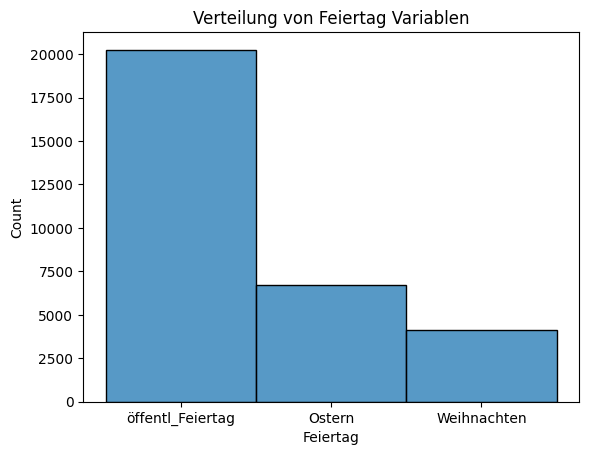

In [ ]:
sns.histplot(df_sales[df_sales.Feiertag != "regulärer_Tag"], x="Feiertag")
plt.title("Verteilung von Feiertag Variablen")
plt.show()

### 1.1.4. <a id='toc1_1_4_'></a>Suche nach fehlenden Werten [&#9650;](#toc0_)

In [ ]:
# Anteil der NA Werte in einer Tabelle zeigen
def percent(df):
    null = df.isnull().sum()
    null_df = pd.DataFrame(null)
    null_df.columns = ["Total"]
    null_df = null_df[null_df["Total"] > 0]
    
    if null_df.empty:
        print("Keine fehlenden Werte")
    else:
        null_df["Anteil_[%]"] = null_df.Total / df.shape[0] * 100
        null_df["Anteil_[%]"] = null_df["Anteil_[%]"].map("{:.2f}".format)
        
    return null_df
percent(df_sales)

,Total,Anteil_[%]
Umsatz_pro_Tag,172817,16.99
Kunden_pro_Tag,172817,16.99
Umsatz_pro_Kunde,172869,16.99


Da es geschlossene Tage mit 0 € Umsatz und 0 Kunden gibt, hat neu erzeugten Spalten fehlende Werte.  
Dies wird in der unteren Grafik ersichtlich. Es gibt viele Werte um 0 €

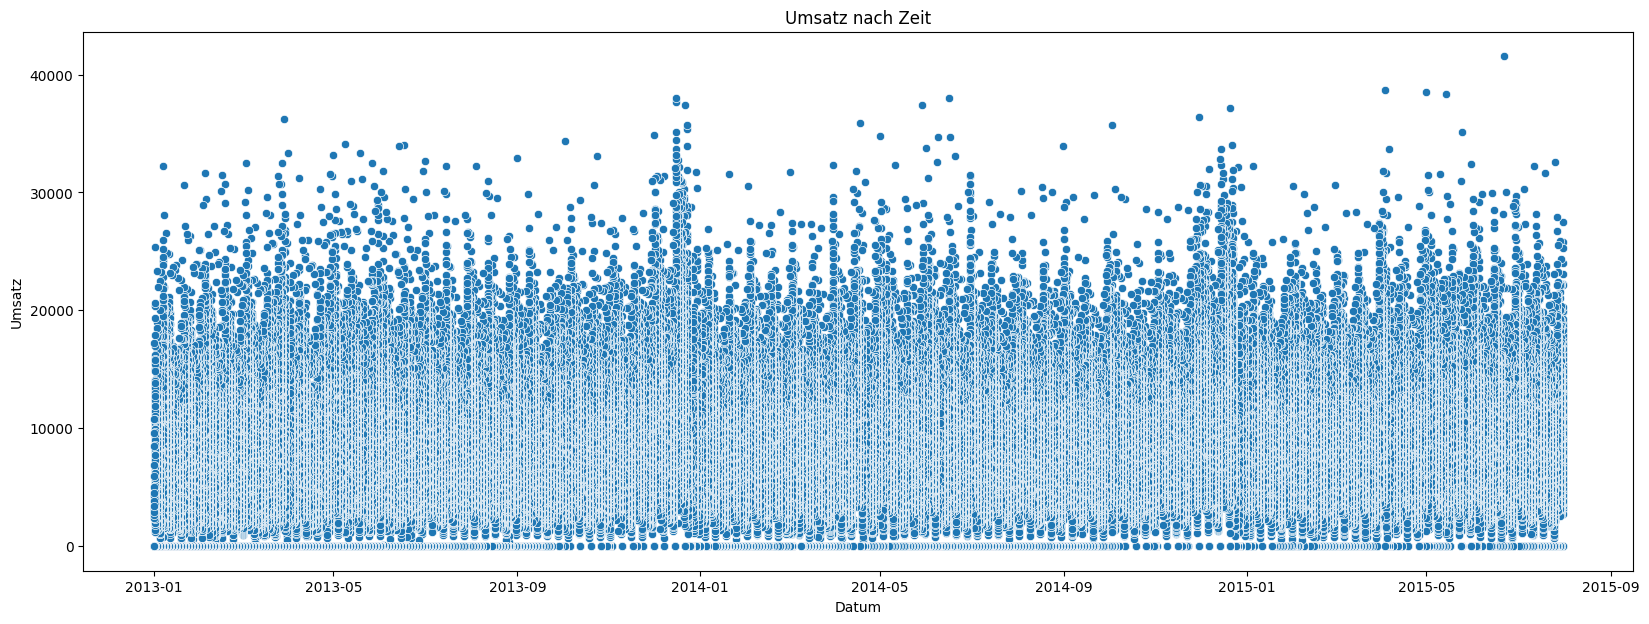

In [ ]:
plt.figure(figsize=(20, 7))
sns.scatterplot(df_sales, x="Datum", y="Umsatz")
plt.title("Umsatz nach Zeit")
plt.show()

In [ ]:
# Filtern nach geschlossen und 0 € Umsatz. Anzeigen der Anzahl von Datenpunkten mit Filter
print(df_sales[(df_sales.Geöffnet == 0) & (df_sales.Umsatz == 0)].shape)
df_sales[(df_sales.Geöffnet == 0) & (df_sales.Umsatz == 0)].head()

(172817, 12)


,Filiale,Wochentag,Datum,Umsatz,Kundenzahl,Geöffnet,Promo,Feiertag,Schulferien,Umsatz_pro_Tag,Kunden_pro_Tag,Umsatz_pro_Kunde
291,292,5,2015-07-31,0,0,0,1,regulärer_Tag,1,NaN,NaN,NaN
875,876,5,2015-07-31,0,0,0,1,regulärer_Tag,1,NaN,NaN,NaN
1406,292,4,2015-07-30,0,0,0,1,regulärer_Tag,1,NaN,NaN,NaN
1990,876,4,2015-07-30,0,0,0,1,regulärer_Tag,1,NaN,NaN,NaN
2521,292,3,2015-07-29,0,0,0,1,regulärer_Tag,1,NaN,NaN,NaN


172817 Tage sind geschlossen und erbringen keine Einnahmen. Wie sieht es mit  
geöffneten Tagen aber ohne Einnahmen aus?

In [ ]:
# Filtern nach Geöffnet und 0 € Umsatz
print(df_sales[(df_sales.Geöffnet != 0) & (df_sales.Umsatz == 0)].shape)
df_sales[(df_sales.Geöffnet != 0) & (df_sales.Umsatz == 0)].head()

(54, 12)


,Filiale,Wochentag,Datum,Umsatz,Kundenzahl,Geöffnet,Promo,Feiertag,Schulferien,Umsatz_pro_Tag,Kunden_pro_Tag,Umsatz_pro_Kunde
86825,971,5,2015-05-15,0,0,1,0,regulärer_Tag,1,0.0,0.0,NaN
142278,674,4,2015-03-26,0,0,1,0,regulärer_Tag,0,0.0,0.0,NaN
196938,699,4,2015-02-05,0,0,1,1,regulärer_Tag,0,0.0,0.0,NaN
322053,708,3,2014-10-01,0,0,1,1,regulärer_Tag,0,0.0,0.0,NaN
330176,357,1,2014-09-22,0,0,1,0,regulärer_Tag,0,0.0,0.0,NaN


Es gibt auch Tage an denen eine Filiale geöffnet hat, aber keine Einnahmen erzielt. Tage ohne Einnahmen werden am Ende dieses Kapitel rausgefiltert, da die Daten für das Feature Engineering gleich noch benötigt werden.

### 1.1.5. <a id='toc1_1_5_'></a>Suche nach Duplikaten [&#9650;](#toc0_)

In [ ]:
df_sales.duplicated().sum()

0

Es sind keine Duplikate vorhanden.

## 1.2. <a id='toc1_2_'></a>df_store [&#9650;](#toc0_)

In [ ]:
round(df_store_raw.describe().T)

,count,mean,std,min,25%,50%,75%,max
Store,1115.0,558.0,322.0,1.0,280.0,558.0,836.0,1115.0
CompetitionDistance,1112.0,5405.0,7663.0,20.0,718.0,2325.0,6882.0,75860.0
CompetitionOpenSinceMonth,761.0,7.0,3.0,1.0,4.0,8.0,10.0,12.0
CompetitionOpenSinceYear,761.0,2009.0,6.0,1900.0,2006.0,2010.0,2013.0,2015.0
Promo2,1115.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
Promo2SinceWeek,571.0,24.0,14.0,1.0,13.0,22.0,37.0,50.0
Promo2SinceYear,571.0,2012.0,2.0,2009.0,2011.0,2012.0,2013.0,2015.0


In [ ]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### 1.2.1. <a id='toc1_2_1_'></a>Daten übersetzen [&#9650;](#toc0_)

Wie auch bei df_sales werden die Spalten erst übersetzt.

In [ ]:
df_store = df_store_raw.copy()

spalten_eng = ['Store', 'StoreType', 'Assortment', 'CompetitionDistance','CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2','Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
spalten_deu = ["Filiale", "Geschäftstyp", "Sortiment", "Wettbew_Distanz", "Wettbew_offen_seit_Monat", "Wettbew_offen_seit_Jahr", "Promo2", "Promo2_seit_Woche", "Promo2_seit_Jahr", "Promo2_Intervall"]

df_store.columns = spalten_deu
df_store.columns

Index(['Filiale', 'Geschäftstyp', 'Sortiment', 'Wettbew_Distanz',
       'Wettbew_offen_seit_Monat', 'Wettbew_offen_seit_Jahr', 'Promo2',
       'Promo2_seit_Woche', 'Promo2_seit_Jahr', 'Promo2_Intervall'],
      dtype='object')

### 1.2.2. <a id='toc1_2_2_'></a>Daten Dimensionen und Formate [&#9650;](#toc0_)

In [ ]:
print(df_store.shape)
df_store.dtypes

(1115, 10)


Filiale                       int64
Geschäftstyp                 object
Sortiment                    object
Wettbew_Distanz             float64
Wettbew_offen_seit_Monat    float64
Wettbew_offen_seit_Jahr     float64
Promo2                        int64
Promo2_seit_Woche           float64
Promo2_seit_Jahr            float64
Promo2_Intervall             object
dtype: object

### 1.2.3. <a id='toc1_2_3_'></a>Suche nach fehlenden Werten [&#9650;](#toc0_)

In [ ]:
percent(df_store)

,Total,Anteil_[%]
Wettbew_Distanz,3,0.27
Wettbew_offen_seit_Monat,354,31.75
Wettbew_offen_seit_Jahr,354,31.75
Promo2_seit_Woche,544,48.79
Promo2_seit_Jahr,544,48.79
Promo2_Intervall,544,48.79


Für mehrere Spalten gibt es fehlende Werte. Diese werden im Folgenden nacheinander bearbeitet.

### 1.2.4. <a id='toc1_2_4_'></a>Imputation [&#9650;](#toc0_)

#### 1.2.4.1. <a id='toc1_2_4_1_'></a>Wettbewerber_Distanz [&#9650;](#toc0_)

In [ ]:
df_store[pd.isnull(df_store.Wettbew_Distanz)]

,Filiale,Geschäftstyp,Sortiment,Wettbew_Distanz,Wettbew_offen_seit_Monat,Wettbew_offen_seit_Jahr,Promo2,Promo2_seit_Woche,Promo2_seit_Jahr,Promo2_Intervall
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


Die Werte scheinen zufällig zu fehlen, jedoch kann es sein, dass die Distanz zu hoch ist, weshalb die Werte für einige Stores fehlen.  
Jedoch ist dies Spekulation und die Werte werden mit dem Median gefüllt.

In [ ]:
df_store['Wettbew_Distanz'] = df_store['Wettbew_Distanz'].fillna(df_store['Wettbew_Distanz'].median())

#### 1.2.4.2. <a id='toc1_2_4_2_'></a>Promo2_Interval, _seit_Woche und _seit_Jahr [&#9650;](#toc0_)

Die drei Spalten haben die gleiche Anzahl an fehlenden Werten. Wenn wir und das genauer anschauen, wird ersichtlich, dass diese Filialen nicht an Promo2 teilnehmen. Daher werden Die Werte einfach auf 0 gesetzt.

In [ ]:
df_store[pd.isnull(df_store.Promo2_Intervall)]

,Filiale,Geschäftstyp,Sortiment,Wettbew_Distanz,Wettbew_offen_seit_Monat,Wettbew_offen_seit_Jahr,Promo2,Promo2_seit_Woche,Promo2_seit_Jahr,Promo2_Intervall
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


Daher überprüfen wir ob es Null Werte bei Filialen mit Promo2=1 gibt

In [ ]:
# Filterung nach Promo2 ungleich 0 und Promo2_Intervall ohne Angaben
df_store[pd.isnull(df_store.Promo2_Intervall) & df_store.Promo2 != 0]

,Filiale,Geschäftstyp,Sortiment,Wettbew_Distanz,Wettbew_offen_seit_Monat,Wettbew_offen_seit_Jahr,Promo2,Promo2_seit_Woche,Promo2_seit_Jahr,Promo2_Intervall


Wie erwartet nehmen diese Filialen nicht an Promo2 teil und kriegen den Wert 0.

In [ ]:
df_store["Promo2_Intervall"] = df_store["Promo2_Intervall"].fillna(0)
df_store["Promo2_seit_Woche"] = df_store["Promo2_seit_Woche"].fillna(0)
df_store["Promo2_seit_Jahr"] = df_store["Promo2_seit_Jahr"].fillna(0)

#### 1.2.4.3. <a id='toc1_2_4_3_'></a>Wettbew_offen_seit_Jahr und _offen_seit_Monat mit KNNImputer [&#9650;](#toc0_)

In [ ]:
df_store[pd.isnull(df_store.Wettbew_offen_seit_Jahr)].head()

,Filiale,Geschäftstyp,Sortiment,Wettbew_Distanz,Wettbew_offen_seit_Monat,Wettbew_offen_seit_Jahr,Promo2,Promo2_seit_Woche,Promo2_seit_Jahr,Promo2_Intervall
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,0.0,0.0,0
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


Obwohl es Wettbewerber für die Filiale gibt, gibt es keine Angaben über das Öffnungsdatum der Wettbewerber. Daher werden diese Werte mittels KNN Imputer geüllt. Für den prozess werden temporäre Dataframes erstellt.

OneHotEncoding von Feiertag Spalte

In [ ]:
df_sales_temp = df_sales.copy()

# OneHotEncoding für "Feiertag" in df_sales
ohe = OneHotEncoder(sparse_output=False)
enc_columns = ohe.fit_transform(df_sales_temp[['Feiertag']])
# Dataframe with encoded columns
encoded_df = pd.DataFrame(enc_columns,
                          columns=ohe.get_feature_names_out(["Feiertag"]))
# adding encoded columns to train
df_sales_temp = pd.concat([df_sales, encoded_df], axis=1).drop("Feiertag", axis=1)
old_names_feiertag = list(ohe.get_feature_names_out(["Feiertag"]))

# nach store aggregieren
df_sales_temp = df_sales_temp.drop(["Wochentag","Datum"], axis=1).groupby("Filiale").sum().reset_index().astype("int")

Umsatz und Kunden pro Tag

In [ ]:
# Kombinieren
df_combined_temp = pd.merge(df_sales_temp, df_store, how = 'left', on = 'Filiale')

# interaktionen SalesPerDay, CustomersPerDay, SalesPerCustomer
df_combined_temp["Umsatz_pro_Tag"] = df_combined_temp.Umsatz//df_combined_temp.Geöffnet
df_combined_temp["Kunden_pro_Tag"] = df_combined_temp.Kundenzahl//df_combined_temp.Geöffnet

OneHotEncoding Geschäftstyp, Sortiment und Promo2_Interall

In [ ]:
# Storetype OneHotEncoding
enc_columns = ohe.fit_transform(df_combined_temp[["Geschäftstyp"]])
encoded_df = pd.DataFrame(enc_columns,
                          columns=ohe.get_feature_names_out(["Geschäftstyp"]))
df_combined_temp = pd.concat([df_combined_temp, encoded_df], axis=1).drop("Geschäftstyp", axis=1)

# Assortment OneHotEncoding
enc_columns = ohe.fit_transform(df_combined_temp[["Sortiment"]])
encoded_df = pd.DataFrame(enc_columns,
                          columns=ohe.get_feature_names_out(["Sortiment"]))
df_combined_temp = pd.concat([df_combined_temp, encoded_df], axis=1).drop("Sortiment", axis=1)

# PromoInterval OneHotEncoding
enc_columns = ohe.fit_transform(df_combined_temp[["Promo2_Intervall"]].astype("str"))
encoded_df = pd.DataFrame(enc_columns,
                          columns=ohe.get_feature_names_out(["Promo2_Intervall"]))
df_combined_temp = pd.concat([df_combined_temp, encoded_df], axis=1).drop("Promo2_Intervall", axis=1)

KNN Imputer

In [ ]:
# Initialisiere den KNN-Imputer
imputer = KNNImputer(n_neighbors=2)
# Fitte und transform den Imputer mit dem gesamten DataFrame
imputer.fit(df_combined_temp)
df_combined_imputed = imputer.transform(df_combined_temp)
# Wandle das NumPy-Array zurück in einen DataFrame und behalte die ursprünglichen Spaltennamen bei
df_combined_temp = pd.DataFrame(df_combined_imputed, columns=df_combined_temp.columns)

# Imputierte Werte für "PromoInterval" runden
df_combined_temp['Wettbew_offen_seit_Monat'] = np.round(df_combined_temp['Wettbew_offen_seit_Monat']).astype("int")
df_combined_temp['Wettbew_offen_seit_Jahr'] = np.round(df_combined_temp['Wettbew_offen_seit_Jahr']).astype("int")

In [ ]:
# Spalten, die ersetzt werden sollen
columns_to_impute = ['Wettbew_offen_seit_Monat', 'Wettbew_offen_seit_Jahr']

## Nullwerte in df_imputed basierend auf df_combined ersetzen
for column in columns_to_impute:
    df_store[column] = df_store.apply(
        lambda row: df_combined_temp[df_combined_temp['Filiale'] == row['Filiale']][column].values[0] if pd.isnull(row[column]) else row[column],
        axis=1
    )

Abschließende Kontrolle ob alle fehlenden Werte imputiert wurden

In [ ]:
percent(df_store)

Keine fehlenden Werte


,Total


Alle fehlenden Werte wurden erfolgreich imputiert.

### 1.2.5. <a id='toc1_2_5_'></a>Dublikate [&#9650;](#toc0_)

In [ ]:
df_store.duplicated().sum()

0

### 1.2.6. <a id='toc1_2_6_'></a>Dateiformate [&#9650;](#toc0_)

Nach der Imputation können wir uns nun erneut die Dateiformate anschauen und entsprechende Spalten näher betrachten

In [ ]:
df_store.dtypes

Filiale                       int64
Geschäftstyp                 object
Sortiment                    object
Wettbew_Distanz             float64
Wettbew_offen_seit_Monat    float64
Wettbew_offen_seit_Jahr     float64
Promo2                        int64
Promo2_seit_Woche           float64
Promo2_seit_Jahr            float64
Promo2_Intervall             object
dtype: object

Zunächst einige floats in int umwandeln und Sortiment Variablen entsprechend benennen

In [ ]:
# dtypes umändern in int
to_str = ['Wettbew_Distanz',"Promo2_seit_Woche", 'Wettbew_offen_seit_Monat', 'Wettbew_offen_seit_Jahr', 'Promo2_seit_Jahr']
df_store[to_str] = df_store[to_str].astype("int")

# Variablen für Sortiment umbennen
dict_assort = {'a': 'basic', 'b': 'extra','c': 'extended'}
df_store['Sortiment'] = df_store['Sortiment'].apply(lambda x: dict_assort[x])

### 1.2.7. <a id='toc1_2_7_'></a>kategoriale Spalten [&#9650;](#toc0_)

Es gibt 4 Geschäftstypen von denen Typ-a mit 602 Filialen am meisten vertreten ist. 348 Filialen sind Typ-d und 148 sind -c. den Typ-b gibt es mit 17 Filialen am wenigsten.

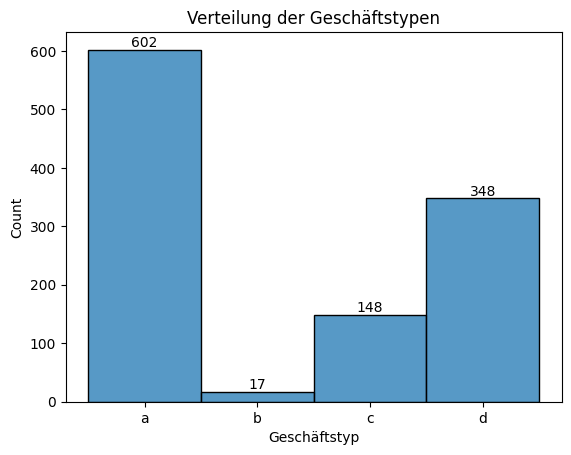

In [ ]:
sns.histplot(df_store.sort_values("Geschäftstyp"), x="Geschäftstyp")
plt.title("Verteilung der Geschäftstypen")
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
plt.show()

Das basic Sortiment gibt es 593 mal und das extended Sortiment 513 mal. Auch hier gibt es einen selteneren Typ, das extra Sortiment mit 9 Filialen.

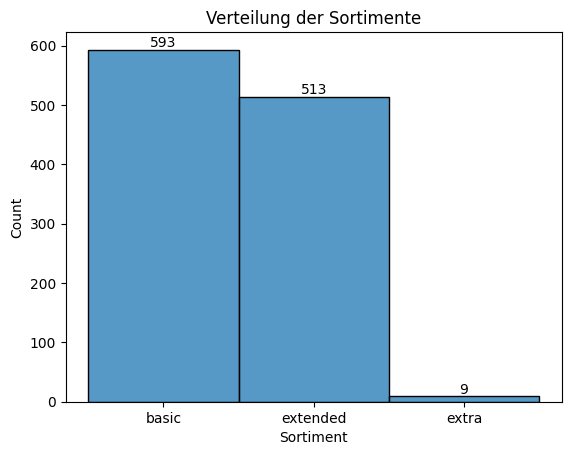

In [ ]:
sns.histplot(df_store.sort_values("Sortiment"), x="Sortiment")
plt.title("Verteilung der Sortimente")
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
plt.show()

Bei der Verteilung der Promo2 Intervalle wird deutlich, dass die Hälfte der Stores nicht an Promo2 teilnehmen. Bei den teilnehmenden Store wird die Rotation Jan,Apr,Jul,Okt am meisten verwendet.

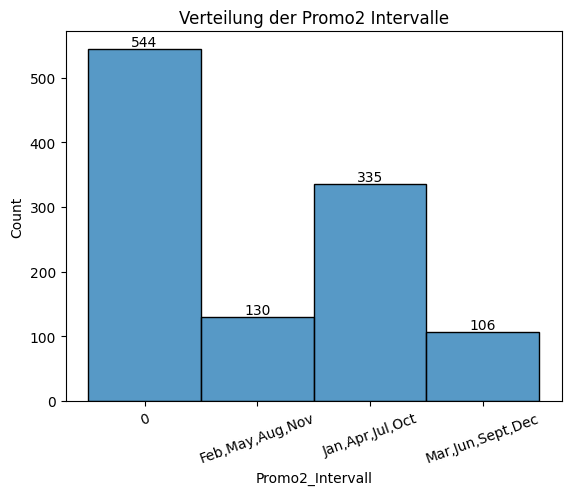

In [ ]:
df_store.Promo2_Intervall = df_store.Promo2_Intervall.astype(str)
sns.histplot(df_store.sort_values("Promo2_Intervall"), x="Promo2_Intervall")
plt.title("Verteilung der Promo2 Intervalle")
plt.xticks(rotation=20)
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
plt.show()

## 1.3. <a id='toc1_3_'></a>Dataframes kombinieren und Infos aus Features extrahieren [&#9650;](#toc0_)

### 1.3.1. <a id='toc1_3_1_'></a>Dataframes zu df_daily kombinieren [&#9650;](#toc0_)

In [ ]:
# Kombinieren von df_sales und df_store
df_daily = pd.merge(df_sales, df_store, how = 'inner', on = 'Filiale')
print(f"shape der kombinieretn Ansicht auf täglicher Basis {df_daily.shape}")
df_daily.head()

shape der kombinieretn Ansicht auf täglicher Basis (1017209, 21)


,Filiale,Wochentag,Datum,Umsatz,Kundenzahl,Geöffnet,Promo,Feiertag,Schulferien,Umsatz_pro_Tag,Kunden_pro_Tag,Umsatz_pro_Kunde,Geschäftstyp,Sortiment,Wettbew_Distanz,Wettbew_offen_seit_Monat,Wettbew_offen_seit_Jahr,Promo2,Promo2_seit_Woche,Promo2_seit_Jahr,Promo2_Intervall
0,1,5,2015-07-31,5263,555,1,1,regulärer_Tag,1,5263.0,555.0,9.482883,c,basic,1270,9,2008,0,0,0,0
1,2,5,2015-07-31,6064,625,1,1,regulärer_Tag,1,6064.0,625.0,9.702400,a,basic,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,regulärer_Tag,1,8314.0,821.0,10.126675,a,basic,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,regulärer_Tag,1,13995.0,1498.0,9.342457,c,extended,620,9,2009,0,0,0,0
4,5,5,2015-07-31,4822,559,1,1,regulärer_Tag,1,4822.0,559.0,8.626118,a,basic,29910,4,2015,0,0,0,0


Feiertag wird auf die einzelnen Parameter aufgespalten um die Summe an Tagen für jede Variable bei der Aggregation zu berechnen.

In [ ]:
# OneHotEncoding für "StateHoliday"
ohe = OneHotEncoder(sparse_output=False)
enc_columns = ohe.fit_transform(df_daily[['Feiertag']])

# Dataframe with encoded columns
encoded_df_daily = pd.DataFrame(enc_columns, columns=ohe.categories_[0], index=df_daily.index)
    
# adding encoded columns to train
df_daily = pd.concat([df_daily, encoded_df_daily], axis=1).drop("Feiertag", axis=1)
df_daily.head(1)

,Filiale,Wochentag,Datum,Umsatz,Kundenzahl,Geöffnet,Promo,Schulferien,Umsatz_pro_Tag,Kunden_pro_Tag,Umsatz_pro_Kunde,Geschäftstyp,Sortiment,Wettbew_Distanz,Wettbew_offen_seit_Monat,Wettbew_offen_seit_Jahr,Promo2,Promo2_seit_Woche,Promo2_seit_Jahr,Promo2_Intervall,Ostern,Weihnachten,regulärer_Tag,öffentl_Feiertag
0,1,5,2015-07-31,5263,555,1,1,1,5263.0,555.0,9.482883,c,basic,1270,9,2008,0,0,0,0,0.0,0.0,1.0,0.0


### 1.3.2. <a id='toc1_3_2_'></a>Promo2 Features [&#9650;](#toc0_)

Wir wissen aus den Daten welche Filialen an Promo2 teilnehmen und in welchem Zyklus sie stattfindet. Daher erstellen wie eine neue Spalte mir ist_Promo2, die auf einer täglichen Basis angibt ob Promo2 grade läuft

In [ ]:
# temporäre Moantsmapping vornehmen 
months = {1: 'Jan', 2: 'Feb', 3: 'Mär', 4: 'Apr', 5: 'Mai', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dez'}
df_daily['month_map'] = df_daily['Datum'].dt.month.apply(lambda x: months[x])

# ist_Promo2 mit aktiver Promo2 für den Tag, wenn Monat im Intervall ist
df_daily['ist_Promo2'] = df_daily.apply(lambda x: 0 if x['Promo2_Intervall'] == 0 else 1 if x['month_map'] in x['Promo2_Intervall'].split(',') else 0, axis = 1)
df_daily = df_daily.drop("month_map", axis=1)
df_daily.ist_Promo2

0          0
1          1
2          1
3          0
4          0
          ..
1017204    1
1017205    0
1017206    0
1017207    0
1017208    0
Name: ist_Promo2, Length: 1017209, dtype: int64

Die Jahres und Wochenangabe wird temporär kombniert um die Dauer der Promo2 in Wochen zu berechnen

In [ ]:
# Promo2_seit aus Jahr und Woche extrahieren
df_daily['Promo2_seit'] = np.where(df_daily['Promo2_seit_Jahr'] != 0,
                                   df_daily['Promo2_seit_Jahr'].astype(str) + '-' + df_daily['Promo2_seit_Woche'].astype(str),
                                   np.nan)

# Promo2_seit in Datetime Format
df_daily['Promo2_seit'] = df_daily['Promo2_seit'].apply(lambda x: datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days=7) if pd.notna(x) else np.nan)

# Berechne Promo2_seit_Wochen --> Promo2_seit vom aktuellen Datum subtrahieren
df_daily['Promo2_seit_Wochen'] = np.where(pd.notna(df_daily['Promo2_seit']),
                                          ((df_daily['Datum'] - df_daily['Promo2_seit']).dt.days / 7),
                                          0)
df_daily['Promo2_seit_Wochen'] = round(df_daily['Promo2_seit_Wochen']).astype(int)

# temporäre Spalte Promo2_seit löschen
df_daily.drop(columns=(["Promo2_seit"]), inplace=True)
df_daily["Promo2_seit_Wochen"].describe()

count    1.017209e+06
mean     5.466500e+01
std      8.580439e+01
min     -1.260000e+02
25%      0.000000e+00
50%      0.000000e+00
75%      1.100000e+02
max      3.140000e+02
Name: Promo2_seit_Wochen, dtype: float64

Im Schnitt läuft Promo2 seit 85 Wochen, aber da Filialen erst im Laufe der Zeit mit Promo2 angefangen haben, gibt es negative Wochen. Diese zeigen an, in wie vielen Wochen die Promo2 anfängt

### 1.3.3. <a id='toc1_3_3_'></a>Wettbewerber Features [&#9650;](#toc0_)

Gleiches wie bei Promo2 wurde für Wettbewerber erstellt. Hier wird die Dauer seit der Eröffnung vom Wettbewerber in Monaten berechnet.

In [ ]:
# Wettbew_seit aus Jahr und Monat durch Kombination extrahieren
df_daily['Wettbew_seit'] = df_daily.apply(lambda x: datetime(year = x['Wettbew_offen_seit_Jahr'], month = x['Wettbew_offen_seit_Monat'], day = 1), axis = 1)
df_daily['Wettbew_seit_Monaten'] = ((df_daily['Datum'] - df_daily['Wettbew_seit']) / 30).apply(lambda x: x.days).astype(int)

# Berechne Wettbew_seit_Monaten --> Wettbew_seit vom aktuellen Datum subtrahieren
df_daily.drop(columns=(['Wettbew_seit']), inplace=True)
df_daily['Wettbew_seit_Monaten'].describe()

count    1.017209e+06
mean     6.239011e+01
std      7.383035e+01
min     -3.200000e+01
25%      1.900000e+01
50%      5.500000e+01
75%      9.100000e+01
max      1.407000e+03
Name: Wettbew_seit_Monaten, dtype: float64

Im Schnitt sind Wettbewerber 62 Monate alt, wobei es auch hier Filialen gibt die erst im Laufe der Zeit Wettbewerber erhalten haben. Daher die negativen Monate.

### 1.3.4. <a id='toc1_3_4_'></a>Bundesländer Mapping nach Schulferien [&#9650;](#toc0_)

Um das Bundesland für jede Filiale zu bestimmen, werden die Infos aus der Spalte Schulferien extrahiert, da jedes Bundesland seine eigenen Daten für Schulferien hat. Diese Daten werden mit der Angabe Schulferien in unserem Datensatz verglichen.

Zunächst wird eine Excel Datei aus 3 Excel Dateien mit den Schulferien für die Jahre 2013 bis 2015 zusammengefügt und als dataframe eingelesen. (Quelle der Excel Dateien:https://www.kalenderpedia.de/ferien/ferien-2013.html).

In [ ]:
df_ferien = pd.read_excel("..//Datafiles//schulferien-2013-2015.xlsx")
# kleine Korrektur bei den Spaltennamen
df_ferien.columns = ['Bundesländer', "vor 2013", 'Winter 2013', 'Ostern 2013', 'Pfingsten 2013',
       'Sommer 2013', 'Herbst 2013', 'Weihnachten 2013', 'Winter 2014',
       'Ostern 2014', 'Pfingsten 2014', 'Sommer 2014', 'Herbst 2014',
       'Weihnachten 2014', 'Winter 2015', 'Ostern  2015',
       'Pfingsten  2015', 'Sommer  2015', 'Herbst  2015']
df_ferien.drop(columns="Herbst  2015", inplace=True)
df_ferien.head()

,Bundesländer,vor 2013,Winter 2013,Ostern 2013,Pfingsten 2013,Sommer 2013,Herbst 2013,Weihnachten 2013,Winter 2014,Ostern 2014,Pfingsten 2014,Sommer 2014,Herbst 2014,Weihnachten 2014,Winter 2015,Ostern 2015,Pfingsten 2015,Sommer 2015
0,Baden_Württemberg,01.01-05.01,-,25.03.-05.04.,21.05.-01.06.,25.07.-07.09.,28.10.-31.10.,23.12.-04.01.,-,14.04.-25.04.,10.06.-21.06.,31.07.-13.09.,27.10.-31.10.,22.12.-05.01.,-,30.03.-10.04.,26.05.-06.06.,30.07.-12.09.
1,Bayern,01.01-05.01,11.02.-15.02.,25.03.-06.04.,21.05.-31.05.,31.07.-11.09.,28.10.-31.10.,23.12.-04.01.,03.03.-07.03.,14.04.-26.04.,10.06.-21.06.,30.07.-15.09.,27.10.-31.10.,24.12.-05.01.,16.02.-20.02.,30.03.-11.04.,26.05.-05.06.,01.08.-14.09.
2,Berlin,01.01-04.01,04.02.-09.02.,25.03.-06.04.,10.05./21.05.,19.06.-02.08.,30.09.-12.10.,23.12.-03.01.,03.02.-08.02.,14.04.-26.04.,02.05./30.05.,10.07.-22.8.,20.10.-01.11.,22.12.-02.01.,02.02.-07.02.,30.03.-11.04.,15.05./26.05.,16.7.-28.8.
3,Brandenburg,01.01-04.01,04.02.-09.02.,27.03.-06.04.,10.05.-10.05.,20.06.-02.08.,30.09.-12.10.,23.12.-03.01.,03.02.-08.02.,16.04.-26.04.,02.05./30.05.,10.07.-22.08.,20.10.-01.11.,22.12.-02.01.,02.02.-07.02.,01.04.-11.04.,15.05.-15.05.,16.07.-28.08.
4,Bremen,01.01-05.01,31.01.-01.02.,16.03.-02.04.,21.05.-21.05.,27.06.-07.08.,04.10.-18.10.,23.12.-03.01.,30.01.-31.01.,03.04.-22.04.,10.06.-10.06.,31.07.-10.09.,27.10.-08.11.,22.12.-05.01.,02.02.-03.02.,25.03.-10.04.,26.05.-26.05.,23.07.-02.09.


Die Informationen aus der Exceldatei werden in ein einheitliches Format überführt und als dictionary abgespeichert. Das Format sieht wie folgt aus: {"Bundesland": [(Start_Datum, End_Datum für Ferien 1), (Start_Datum, End_Datum für Ferien 2) usw... ]}. Da Ferien, wie Pfingsten, nicht in jedem Bundesland genutzt werden, haben die dict-Einträge eine unterschiedliche Anzahl an Start-und-End-Paaren für Ferien.

In [ ]:
# Funktion zum Extrahieren der Ferien
def extract_ferien(df, years):
    # Dictionary mit Bundesländer und Ferienzeiten
    ferien_data = {}
    # Für jedes Bundesland ein key Eintrag im dict erstellen
    for index, row in df.iterrows():
        bundesland = row["Bundesländer"]
        ferien_data[bundesland] = []
        # Für Jahre 2013 - 2015 Ferienname und Jahr kombinieren --> Winter 2013, Ostern 2013 ... 
        for year in years:
            for ferien in ["vor", "Winter", "Ostern", "Pfingsten", "Sommer", "Herbst", "Weihnachten"]:
                ferien_key = f"{ferien} {year}"
                if (ferien_key in df.columns) and (row[ferien_key] != "-") and ("-" in row[ferien_key]):
                    # Zellen Eintrag beim Symbol "-" in Start- und End-Datum splitten
                    start, end = row[ferien_key].split("-")
                    # Startdatum Tag.Monat mit Jahr verbinden und "." durch "-" ersetzen
                    start_date = f"{year}-{start.strip().replace('.', '-')}".rstrip('-')
                    # Überprüfen, ob das Enddatum im nächsten Jahr liegt ...
                    if "Weihnachten" in ferien and int(end.strip().split(".")[1]) < int(start.strip().split(".")[1]):
                        # ...wenn ja, das Jahr in Enddatum auf nächstes Jahr setzen
                        end_date = f"{int(year)+1}-{end.strip().replace('.', '-')}".rstrip('-')
                    else:
                        # ...wenn nein, gleiches Jahr benutzen
                        end_date = f"{year}-{end.strip().replace('.', '-')}".rstrip('-')
                    # Formatierung in "Monat-Tag-Jahr"
                    start_date = "-".join(start_date.split("-")[::-1])
                    end_date = "-".join(end_date.split("-")[::-1])
                    ferien_data[bundesland].append((start_date, end_date))
    return ferien_data

# Jahre, die extrahiert werden sollen
years = ["2013", "2014", "2015"]

# Ferien-Daten extrahieren
ferien_data = extract_ferien(df_ferien, years)

# Ergebnis anzeigen
ferien_data

{'Baden_Württemberg': [('01-01-2013', '01-05-2013'),
  ('03-25-2013', '04-05-2013'),
  ('05-21-2013', '06-01-2013'),
  ('07-25-2013', '09-07-2013'),
  ('10-28-2013', '10-31-2013'),
  ('12-23-2013', '01-04-2014'),
  ('04-14-2014', '04-25-2014'),
  ('06-10-2014', '06-21-2014'),
  ('07-31-2014', '09-13-2014'),
  ('10-27-2014', '10-31-2014'),
  ('12-22-2014', '01-05-2015')],
 'Bayern': [('01-01-2013', '01-05-2013'),
  ('02-11-2013', '02-15-2013'),
  ('03-25-2013', '04-06-2013'),
  ('05-21-2013', '05-31-2013'),
  ('07-31-2013', '09-11-2013'),
  ('10-28-2013', '10-31-2013'),
  ('12-23-2013', '01-04-2014'),
  ('03-03-2014', '03-07-2014'),
  ('04-14-2014', '04-26-2014'),
  ('06-10-2014', '06-21-2014'),
  ('07-30-2014', '09-15-2014'),
  ('10-27-2014', '10-31-2014'),
  ('12-24-2014', '01-05-2015'),
  ('02-16-2015', '02-20-2015')],
 'Berlin': [('01-01-2013', '01-04-2013'),
  ('02-04-2013', '02-09-2013'),
  ('03-25-2013', '04-06-2013'),
  ('06-19-2013', '08-02-2013'),
  ('09-30-2013', '10-12-2013'

Anschließend wird überprüft, wie oft die Spalte "Schulferien" für eine Filiale mit allen Einträgen für jedes Bundesländer übereinstimmt. Die Anzahl an matches für Filiale-Bundesland wird gezählt und durch die Anzahl an allen Ferientagen in einem Bundesland geteilt. Das Maximum aus der ratio entscheidet über die Zuordnung. Jedoch werden Schwellenwerte aus dem median der Anzahl matches für jedes Bundesland erstellt. Filialen, die den Schwellenwert nicht erreichen werden ohne Zuordnung seperat abgespeichert. Falls ein maximaler Wert für mehr als ein Bundesland erzielt wird, wird die Filiale ebenfalls ohne Zuordnung seperat abgespeichert. Filialen ohne Zuordnung werden manuell zugeordnet.

In [ ]:
df_länder = df_daily.copy()

# Schwellenwerte für jedes Bundesland erstellt aus dem median an matches für jedes Bundesland plus die Standardabweichung
schwellenwerte = {'Baden_Württemberg': 89,
 'Bayern': 89,
 'Berlin': 84,
 'Brandenburg': 83,
 'Bremen': 74,
 'Hamburg': 68,
 'Hessen': 93,
 'Mecklenburg_Vorp.': 80,
 'Niedersachsen': 73,
 'NRW': 92,
 'Rheinland_Pfalz': 92,
 'Saarland': 93,
 'Sachsen': 92,
 'Sachsen_Anhalt': 89,
 'Schleswig_Holstein': 87,
 'Thüringen': 101}

# Funktion zur Zuordnung der Filialen zu Bundesländern
def zuordnung_bundesland(df, ferien_data, schwellenwerte):
    def check_ferien(dates, ferien):
        # Serie aller Ferienzeiträume erstellen aus Start und Enddatum in ferien_ranges
        ferien_ranges = pd.concat([pd.Series(pd.date_range(start, ende)) for start, ende in ferien])
        counts_matches = dates.isin(ferien_ranges).sum()
        counts_ferientage_bundesland = ferien_ranges.count()
        return counts_matches, counts_ferientage_bundesland

    filialen = df['Filiale'].unique()
    bundesland_zuordnung = {}
    matches_df = pd.DataFrame(index=filialen, columns=ferien_data.keys())
    unzugeordnete_filialen = []
    mehrdeutige_filialen = []

    # Jede Filiale einzeln durcharbeiten
    for filiale in filialen:
        # Filtern nach Store und Schulferien=1
        store_data = df[(df['Filiale'] == filiale) & (df['Schulferien'] == 1)]
        # dictionary mit Bundesländer als key und value = 0 erstellen
        matches = pd.DataFrame([[0]*16], index=[filiale], columns=ferien_data.keys())
        bundesland_ferientage = pd.DataFrame([[0]*16], index=[filiale], columns=ferien_data.keys())
        for bundesland, ferien in ferien_data.items():
            # matches für jedes Bundesland wenn gefiltertes Datum in Ferienzeitraum ist
            matches.at[filiale, bundesland], bundesland_ferientage.at[filiale, bundesland] = check_ferien(store_data['Datum'], ferien)
        # Bundesland mit höchstem ratio zwischen Matches und Anzahl Feiertagen des Bundeslandes 
        best_match = (matches.loc[filiale] / bundesland_ferientage.loc[filiale]).idxmax()
        # Anzahl an Matches
        max_matches = matches.at[filiale, best_match]

        # Überprüfen, ob der Schwellenwert für das beste Bundesland erreicht wurde
        if max_matches >= schwellenwerte[best_match]:
            # Überprüfen, ob der maximal Wert mehrmals vorkommt ...
            if (matches.loc[filiale] == max_matches).sum() > 1:
                # wenn ja, Filialennummer in mehrdeutige_filialen speichern
                mehrdeutige_filialen.append(filiale)
            else:
                # wenn nein, Filialennummer in bundesland_zuordnung speichern
                bundesland_zuordnung[filiale] = best_match
        else:
            # sont in unzugeordnete_Filialen
            unzugeordnete_filialen.append(filiale)
            # Zuordnung von Fililae und Bundesland in sepeartem dataframe
        for bundesland in matches:
            matches_df.at[filiale, bundesland] = matches.at[filiale, bundesland]

    return matches_df, bundesland_zuordnung, unzugeordnete_filialen, mehrdeutige_filialen

# Anwendung der Funktion auf den Rossmann-Datensatz
matches_df, bundesland_zuordnung, unzugeordnete_filialen, mehrdeutige_filialen = zuordnung_bundesland(df_länder, ferien_data, schwellenwerte)

# dict Einträge der Filialen als int abspeichern
bundesland_zuordnung = {int(k): v for k, v in bundesland_zuordnung.items()}

# Minimum und Maximum der erreichten Matches
min_matches = matches_df.min().min()
max_matches = matches_df.max().max()

print(f"Minimum erreichte Matches: {min_matches}")
print(f"Maximum erreichte Matches: {max_matches}")
print(f"Unzugeordnete Filialen: {unzugeordnete_filialen}")
print(f"Mehrdeutige Filialen: {mehrdeutige_filialen}")

Minimum erreichte Matches: 23
Maximum erreichte Matches: 178
Unzugeordnete Filialen: []
Mehrdeutige Filialen: []


Die Schwellenwerte wurden nach dem ersten Durchgang berechnet und für den 2ten Durchgang benutzt

In [ ]:
# nicht nochmal ausführen
schwellenwerte = (matches_df.median()).astype(int)
schwellenwerte.to_dict()

{'Baden_Württemberg': 89,
 'Bayern': 89,
 'Berlin': 84,
 'Brandenburg': 83,
 'Bremen': 74,
 'Hamburg': 68,
 'Hessen': 93,
 'Mecklenburg_Vorp.': 80,
 'Niedersachsen': 73,
 'NRW': 92,
 'Rheinland_Pfalz': 92,
 'Saarland': 93,
 'Sachsen': 92,
 'Sachsen_Anhalt': 89,
 'Schleswig_Holstein': 87,
 'Thüringen': 101}

Bundesländer den Filialen zuordnen

In [ ]:
# Mapping von df['Bundesland']
df_daily['Bundesland'] = df_länder['Filiale'].map(bundesland_zuordnung)

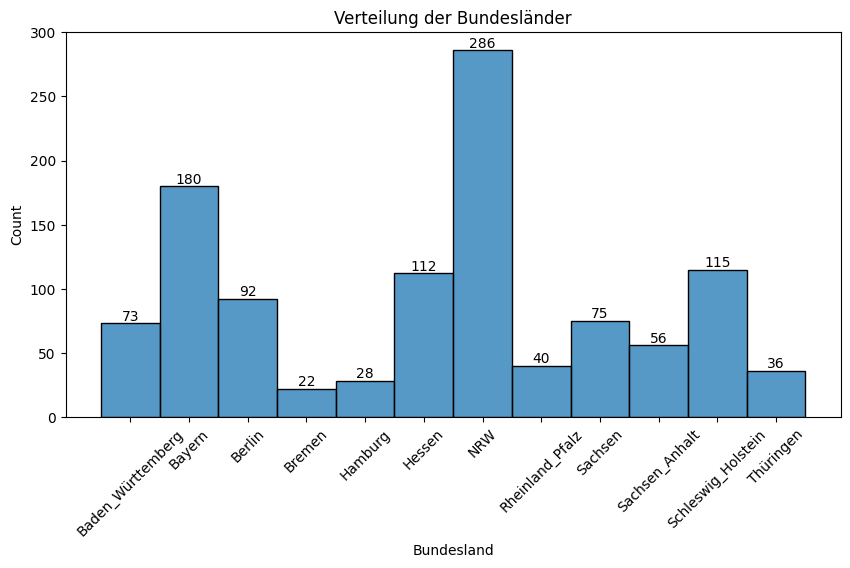

In [ ]:
temp_group = df_daily.groupby("Filiale").agg({"Bundesland": "last"}).reset_index()
plt.figure(figsize=(10,5))
sns.histplot(temp_group.sort_values("Bundesland"), x="Bundesland")
plt.title("Verteilung der Bundesländer")
plt.xticks(rotation=45)
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
plt.show()

Die meisten Daten stammen aus NRW

### 1.3.5. <a id='toc1_3_5_'></a>temporale Features hinzufügen [&#9650;](#toc0_)

Da der Datensatz eine Zeitserie ist, werden temporale Features wie Monat und Kalenderwoche hinzugefügt.

In [ ]:
df_daily["Jahr"] = df_daily.Datum.dt.year
df_daily["Quartal"] = df_daily.Datum.dt.quarter
df_daily["Monat"] = df_daily.Datum.dt.month
df_daily["Monatstag"] = df_daily.Datum.dt.day
df_daily["Kalenderwoche"] = df_daily.Datum.dt.isocalendar().week
df_daily.columns

Index(['Filiale', 'Wochentag', 'Datum', 'Umsatz', 'Kundenzahl', 'Geöffnet',
       'Promo', 'Schulferien', 'Umsatz_pro_Tag', 'Kunden_pro_Tag',
       'Umsatz_pro_Kunde', 'Geschäftstyp', 'Sortiment', 'Wettbew_Distanz',
       'Wettbew_offen_seit_Monat', 'Wettbew_offen_seit_Jahr', 'Promo2',
       'Promo2_seit_Woche', 'Promo2_seit_Jahr', 'Promo2_Intervall', 'Ostern',
       'Weihnachten', 'regulärer_Tag', 'öffentl_Feiertag', 'ist_Promo2',
       'Promo2_seit_Wochen', 'Wettbew_seit_Monaten', 'Bundesland', 'Jahr',
       'Quartal', 'Monat', 'Monatstag', 'Kalenderwoche'],
      dtype='object')

Manche Filialen haben Sonntags offen, daher wird eine entsprechende Spalte mit 1=sonntag_geöffnet und 0=geschlossen erstellt

In [ ]:

# Mapping von Sonntag geöffnet
df_daily["Sonntag"] = np.where((df_daily.Wochentag == 7) & (df_daily.Geöffnet == 1), 1, 0)
round(df_daily.Sonntag.describe())


count    1017209.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            1.0
Name: Sonntag, dtype: float64

### 1.3.6. <a id='toc1_3_6_'></a>Datenpunkte ohne Umsätze rausfiltern [&#9650;](#toc0_)

In [ ]:
# Kopie speichern bevor Filterung gespeichert wird
df_daily_vor_Filterung = df_daily.copy()
df_daily_vor_Filterung.to_parquet("..\\Save_files\\df_daily_vor_Filterung.parquet", engine='pyarrow')

# 0€ Umsatz Daten rausfiltern und als df_sales abspeichern
df_daily = df_daily[(df_daily.Umsatz != 0)]
round(df_daily.Umsatz.describe())


count    844338.0
mean       6956.0
std        3104.0
min          46.0
25%        4859.0
50%        6369.0
75%        8360.0
max       41551.0
Name: Umsatz, dtype: float64

Der Durchschnittle Umsatz liegt nun bei 6956 € und das Minimum bei 46 €.  
In der Grafik unten ist zu erkennen, dass einige Verkaufstage in Richtung  
0 neigen.

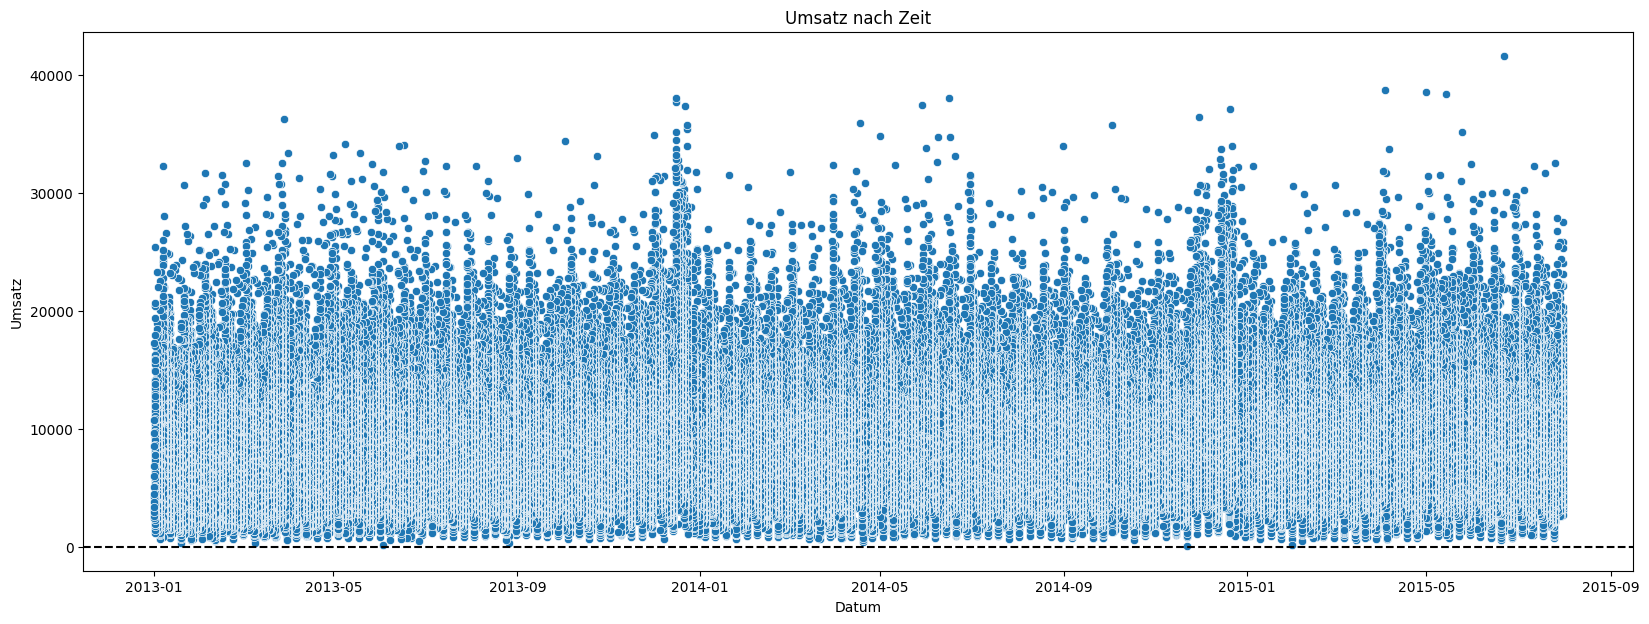

In [ ]:
plt.figure(figsize=(20, 7))
sns.scatterplot(df_daily, x="Datum", y="Umsatz")
plt.title("Umsatz nach Zeit")
plt.axhline(0, color='black', linestyle='--')
plt.show()

In [ ]:
print(df_daily.shape)
percent(df_daily)

(844338, 34)
Keine fehlenden Werte


,Total


### 1.3.7. <a id='toc1_3_7_'></a>aggregierte Ansicht [&#9650;](#toc0_)

In [ ]:
df_agg = df_daily.copy()

# Listen mit Spaltennamen für Aggregationsfunktion "Summe" erstellen 
to_sum = ['Umsatz', 'Kundenzahl', "Umsatz_pro_Tag", "Umsatz_pro_Kunde", 'Kunden_pro_Tag', 'Geöffnet',
          'Promo', 'ist_Promo2', 'Schulferien', 
          'Ostern', 'Weihnachten', 'öffentl_Feiertag',
          'regulärer_Tag', "Sonntag"]

# zweite Liste für Aggregationsfunktion "leter Wert"
to_last = ['Geschäftstyp', 'Sortiment', "Bundesland",
           'Wettbew_Distanz', 'Wettbew_seit_Monaten',
           'Wettbew_offen_seit_Monat', 'Wettbew_offen_seit_Jahr',
           'Promo2', 'Promo2_Intervall', 'Promo2_seit_Wochen', 
           'Promo2_seit_Woche','Promo2_seit_Jahr']

# Aggregationsfunktionen für die Spalten
agg_funcs = {col: 'sum' for col in to_sum}
agg_funcs.update({col: 'last' for col in to_last})

# Nach store aggregieren
df_agg = df_agg.sort_values(["Filiale", "Datum"])
df_agg = df_agg.groupby("Filiale").agg(agg_funcs).reset_index()

# sortieren
df_agg = df_agg.sort_values(["Filiale"])

df_agg.head(5)

,Filiale,Umsatz,Kundenzahl,Umsatz_pro_Tag,Umsatz_pro_Kunde,Kunden_pro_Tag,Geöffnet,Promo,ist_Promo2,Schulferien,Ostern,Weihnachten,öffentl_Feiertag,regulärer_Tag,Sonntag,Geschäftstyp,Sortiment,Bundesland,Wettbew_Distanz,Wettbew_seit_Monaten,Wettbew_offen_seit_Monat,Wettbew_offen_seit_Jahr,Promo2,Promo2_Intervall,Promo2_seit_Wochen,Promo2_seit_Woche,Promo2_seit_Jahr
0,1,3716854,440523,3716854.0,6554.962733,440523.0,781,350,0,160,0.0,0.0,0.0,781.0,0,c,basic,Hessen,1270,84,9,2008,0,0,0,0,0
1,2,3883858,457855,3883858.0,6592.219192,457855.0,784,354,284,153,0.0,0.0,2.0,782.0,0,a,basic,Thüringen,570,94,11,2007,1,"Jan,Apr,Jul,Oct",280,13,2010
2,3,5408261,584310,5408261.0,7102.609730,584310.0,779,350,284,156,0.0,0.0,0.0,779.0,0,a,basic,NRW,14130,105,12,2006,1,"Jan,Apr,Jul,Oct",227,14,2011
3,4,7556507,1036254,7556507.0,5683.864617,1036254.0,784,353,0,159,0.0,0.0,0.0,784.0,0,c,extended,Berlin,620,71,9,2009,0,0,0,0,0
4,5,3642818,418588,3642818.0,6708.147434,418588.0,779,351,0,156,0.0,0.0,3.0,776.0,0,a,basic,Sachsen,29910,4,4,2015,0,0,0,0,0


### 1.3.8. <a id='toc1_3_8_'></a>Gruppierung basierend auf Umsatz pro Kunde [&#9650;](#toc0_)

Die Filialen werden basierend auf dem Spalte Umsatz pro Kunde unterteilt. Dabei werden folgende Quantile benutzt [0, 0.01, 0.11, 0.5, 0.89, 0.99, 1]. Da wir die Daten später für das Trainieren der ML Modelle in train und test Datensätze aufteilen werden, splitten wir die Daten jetzt schon und erstellen die Gruppierung. Für die EDA arbeiten wir dann mit dem Gesamten Datensatz.

Zunächst df_daily splitten und aggregieren, wie oben.

In [ ]:
# Splitten
timestamp = pd.Timestamp(df_daily["Datum"].sort_values().iloc[-1])
split_point = timestamp - pd.Timedelta(days=(7*8))
df_train_group = df_daily[df_daily["Datum"] < split_point].reset_index(drop=True).copy()


# Listen mit Spaltennamen für Aggregationsfunktion erstellen 
to_sum = ['Umsatz', 'Kundenzahl', "Umsatz_pro_Tag", "Umsatz_pro_Kunde", 'Umsatz_pro_Kunde', 'Geöffnet',
          'Promo', 'ist_Promo2', 'Schulferien', 
          'Ostern', 'Weihnachten', 'öffentl_Feiertag',
          'regulärer_Tag', "Sonntag"]

# zweite Liste für Aggregationsfunktion
to_last = ['Geschäftstyp', 'Sortiment', "Bundesland",
           'Wettbew_Distanz', 'Wettbew_seit_Monaten',
           'Wettbew_offen_seit_Monat', 'Wettbew_offen_seit_Jahr',
           'Promo2', 'Promo2_Intervall', 'Promo2_seit_Wochen', 
           'Promo2_seit_Woche','Promo2_seit_Jahr']

# Aggregationsfunktionen für die Spalten
agg_funcs = {col: 'sum' for col in to_sum}
agg_funcs.update({col: 'last' for col in to_last})

# Nach store aggregieren
df_train_group = df_train_group.sort_values(["Filiale", "Datum"])
df_train_group = df_train_group.groupby("Filiale").agg(agg_funcs).reset_index()

# sortieren
df_train_group = df_train_group.sort_values(["Filiale"])

df_train_group.head(5)

,Filiale,Umsatz,Kundenzahl,Umsatz_pro_Tag,Umsatz_pro_Kunde,Geöffnet,Promo,ist_Promo2,Schulferien,Ostern,Weihnachten,öffentl_Feiertag,regulärer_Tag,Sonntag,Geschäftstyp,Sortiment,Bundesland,Wettbew_Distanz,Wettbew_seit_Monaten,Wettbew_offen_seit_Monat,Wettbew_offen_seit_Jahr,Promo2,Promo2_Intervall,Promo2_seit_Wochen,Promo2_seit_Woche,Promo2_seit_Jahr
0,1,3502610,415805,3502610.0,6132.263922,732,329,0,155,0.0,0.0,0.0,732.0,0,c,basic,Hessen,1270,82,9,2008,0,0,0,0,0
1,2,3643513,428945,3643513.0,6180.216263,735,333,257,138,0.0,0.0,2.0,733.0,0,a,basic,Thüringen,570,92,11,2007,1,"Jan,Apr,Jul,Oct",271,13,2010
2,3,5066447,549647,5066447.0,6624.708435,730,329,257,131,0.0,0.0,0.0,730.0,0,a,basic,NRW,14130,103,12,2006,1,"Jan,Apr,Jul,Oct",218,14,2011
3,4,7076699,974228,7076699.0,5306.862810,735,332,0,147,0.0,0.0,0.0,735.0,0,c,extended,Berlin,620,70,9,2009,0,0,0,0,0
4,5,3420909,393378,3420909.0,6279.481598,730,330,0,141,0.0,0.0,3.0,727.0,0,a,basic,Sachsen,29910,2,4,2015,0,0,0,0,0


Filialen den Gruppen zuweisen

In [ ]:

# Grenzen für die Gruppen basierend auf Quantilen
df_train_group['Gruppe'] = pd.qcut(df_train_group['Umsatz_pro_Tag'], q=[0, 0.01, 0.11, 0.5, 0.89, 0.99, 1], labels=["Niedrigste 1%", "Niedrig", "Unteres Mittelfeld", "Oberes Mittelfeld", "Hoch", "Höchste 1%"])
# Definiere die Reihenfolge der Kategorien
category_order = ["Niedrigste 1%", "Niedrig", "Unteres Mittelfeld", "Oberes Mittelfeld", "Hoch", "Höchste 1%"]
df_train_group["Gruppe"] = pd.Categorical(df_train_group["Gruppe"], categories=category_order, ordered=True)

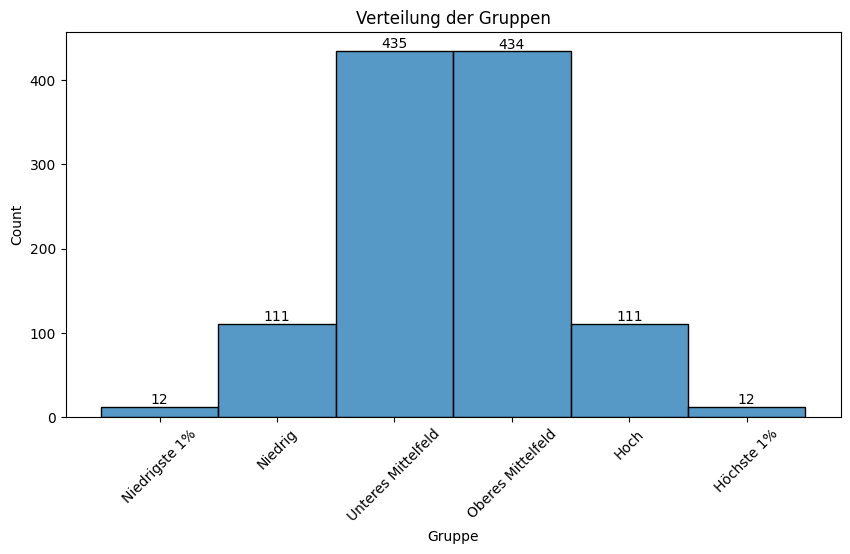

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df_train_group, x="Gruppe")
plt.title("Verteilung der Gruppen")
plt.xticks(rotation=45)
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
plt.show()

Gruppierung df_daily und df_agg hinzufügen

In [ ]:
# Gruppe hinzufügen
df_daily = pd.merge(df_daily, df_train_group[["Filiale", "Gruppe"]], on="Filiale", how="left")
df_agg = pd.merge(df_agg, df_train_group[["Filiale", "Gruppe"]], on="Filiale", how="left")

### 1.3.9. <a id='toc1_3_9_'></a>dataframes als pkl abspeichern [&#9650;](#toc0_)

In [ ]:
df_daily.to_parquet("..\\Save_files\\df_daily.parquet", engine='pyarrow')
df_agg.to_parquet("..\\Save_files\\df_agg.parquet", engine='pyarrow')